In [38]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

2023-06-24 01:59:10 - 2023-07-11 10:49:42
"09 July 2023:	Measurement error with regard to fine dust values due to sudden increase in air humidity"
Nous supprimons les données contenant des informations postérieures au 9 juillet

In [39]:

data=pd.read_csv("./one_room_apartement.csv")

In [40]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [41]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [42]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

In [43]:
nan_rows_count = data.isna().any(axis=1).sum()

print(f"\n Le nombre de lignes contenant des valeurs NaN est de: {nan_rows_count}")


 Le nombre de lignes contenant des valeurs NaN est de: 0


**Nettoyage des données**

Supprimer les lignes Nan et les colonnes de caractéristiques inintéressantes

In [44]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

Nous supprimons les données contenant des informations postérieures au 9 juillet

"température", "pression", "humidité" à la fin des colonnes de données

In [45]:
dates_to_remove = ['2023-07-09','2023-07-10','2023-07-11']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]

Modifier le nom de timestamp et le convertir en index

In [46]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                     oxygen    pm10     co      co2      so2     no2     pm1  \
date                                                                           
2023-07-08 23:40:25  20.771  14.125  1.626  484.797  1139.90  69.921  10.375   
2023-07-08 23:42:24  20.771  13.626  1.625  485.178  1138.44  70.182  10.686   
2023-07-08 23:44:25  20.776  16.510  1.624  488.142  1136.82  70.427  11.233   
2023-07-08 23:46:25  20.778  17.540  1.621  486.802  1134.34  70.437  11.883   
2023-07-08 23:48:26  20.778  18.675  1.619  486.528  1132.36  70.288  12.278   
2023-07-08 23:50:26  20.778  15.895  1.616  485.832  1128.76  70.419  11.941   
2023-07-08 23:52:25  20.778  17.712  1.613  486.623  1123.33  70.439  12.091   
2023-07-08 23:54:26  20.778  15.942  1.611  487.518  1118.35  70.315  11.641   
2023-07-08 23:56:28  20.778  15.670  1.609  490.148  1115.68  69.342  11.238   
2023-07-08 23:58:27  20.776  18.649  1.607  493.541  1114.81  68.738  12.237   

                      dewpt     tvoc   

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

Danger(Alert)
1. PM10   101 ug/m3
2. CO 201 ppm
3. CO2  1001 ppm
4. SO2   81 ug/m3
5. NO2  81ug/m3
6. PM1
7. dewpt
8. TVOC 500 ug/m3
9.  O3  100 ug/m3
10. sound
11. PM2.5    61 ug/m3
12. Température   <21°C.    >30°C.
13. Pression
14. Humidité     <30%   >50%

In [47]:
thresholds = {
    "pm10": 101,
    "co": 201,
    "co2": 1001,
    "so2": 81,
    "no2": 81,
    "tvoc": 500,
    "o3": 100,
    "pm2_5": 61,
    "temperature": (21, 30),
    "humidity": (30, 50)
}

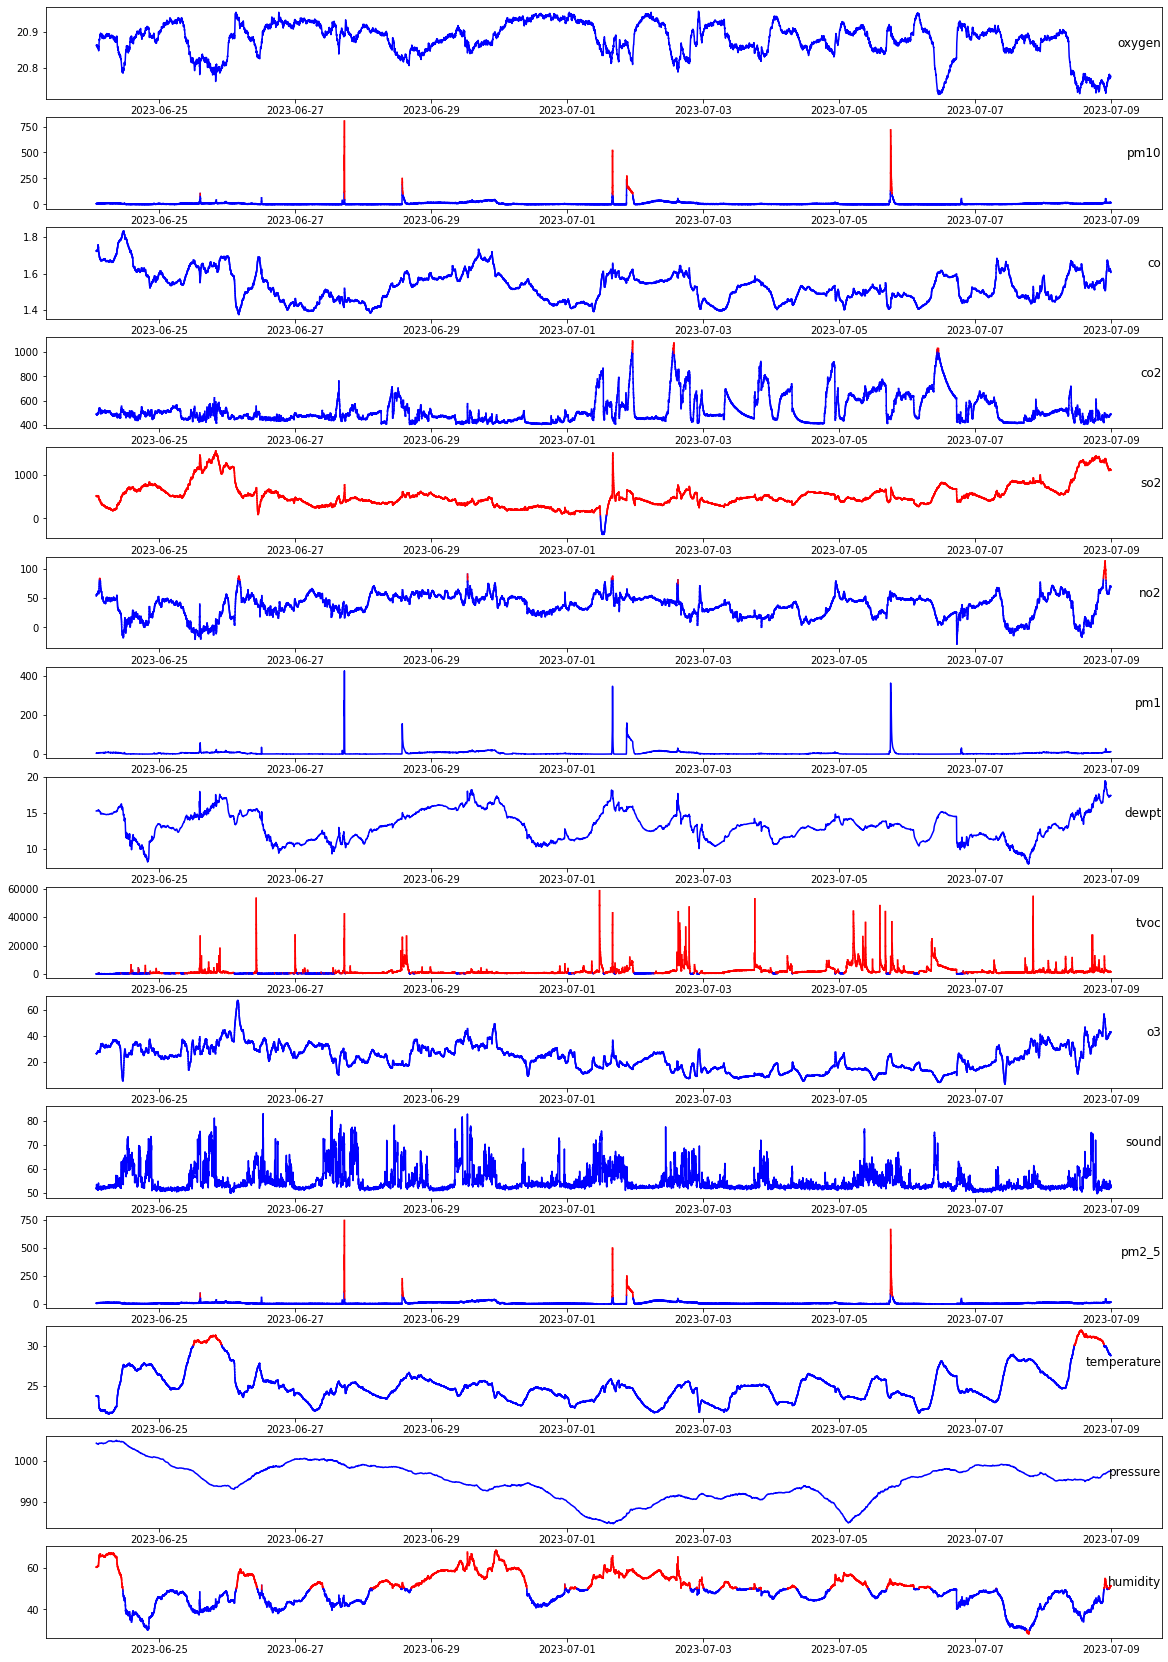

In [48]:
danger_limits  = {
    'pm10': thresholds['pm10'],
    'co': thresholds['co'],
    'co2': thresholds['co2'],
    'so2': thresholds['so2'],
    'no2': thresholds['no2'],
    'tvoc': thresholds['tvoc'],
    'o3': thresholds['o3'],
    'pm2_5': thresholds['pm2_5'],
    'temperature': thresholds['temperature'],
    'humidity': thresholds['humidity']
}

values = data.values
dates = data.index
groups = list(range(data.shape[1]))
i = 1

plt.figure(figsize=(20, 30))
for group in groups:
    col_name = data.columns[group]
    plt.subplot(len(groups), 1, i)
    if col_name in danger_limits:
        if isinstance(danger_limits[col_name], tuple):
            lower, upper = danger_limits[col_name]
            colors = ['red' if x < lower or x > upper else 'blue' for x in values[:, group]]
        else:
            limit = danger_limits[col_name]
            colors = ['red' if x > limit else 'blue' for x in values[:, group]]

        for j in range(len(dates) - 1):
            plt.plot(dates[j:j+2], values[j:j+2, group], color=colors[j])
    else:
        plt.plot(dates, values[:, group], color='blue')
    plt.title(col_name, y=0.5, loc='right')
    i += 1
plt.show()

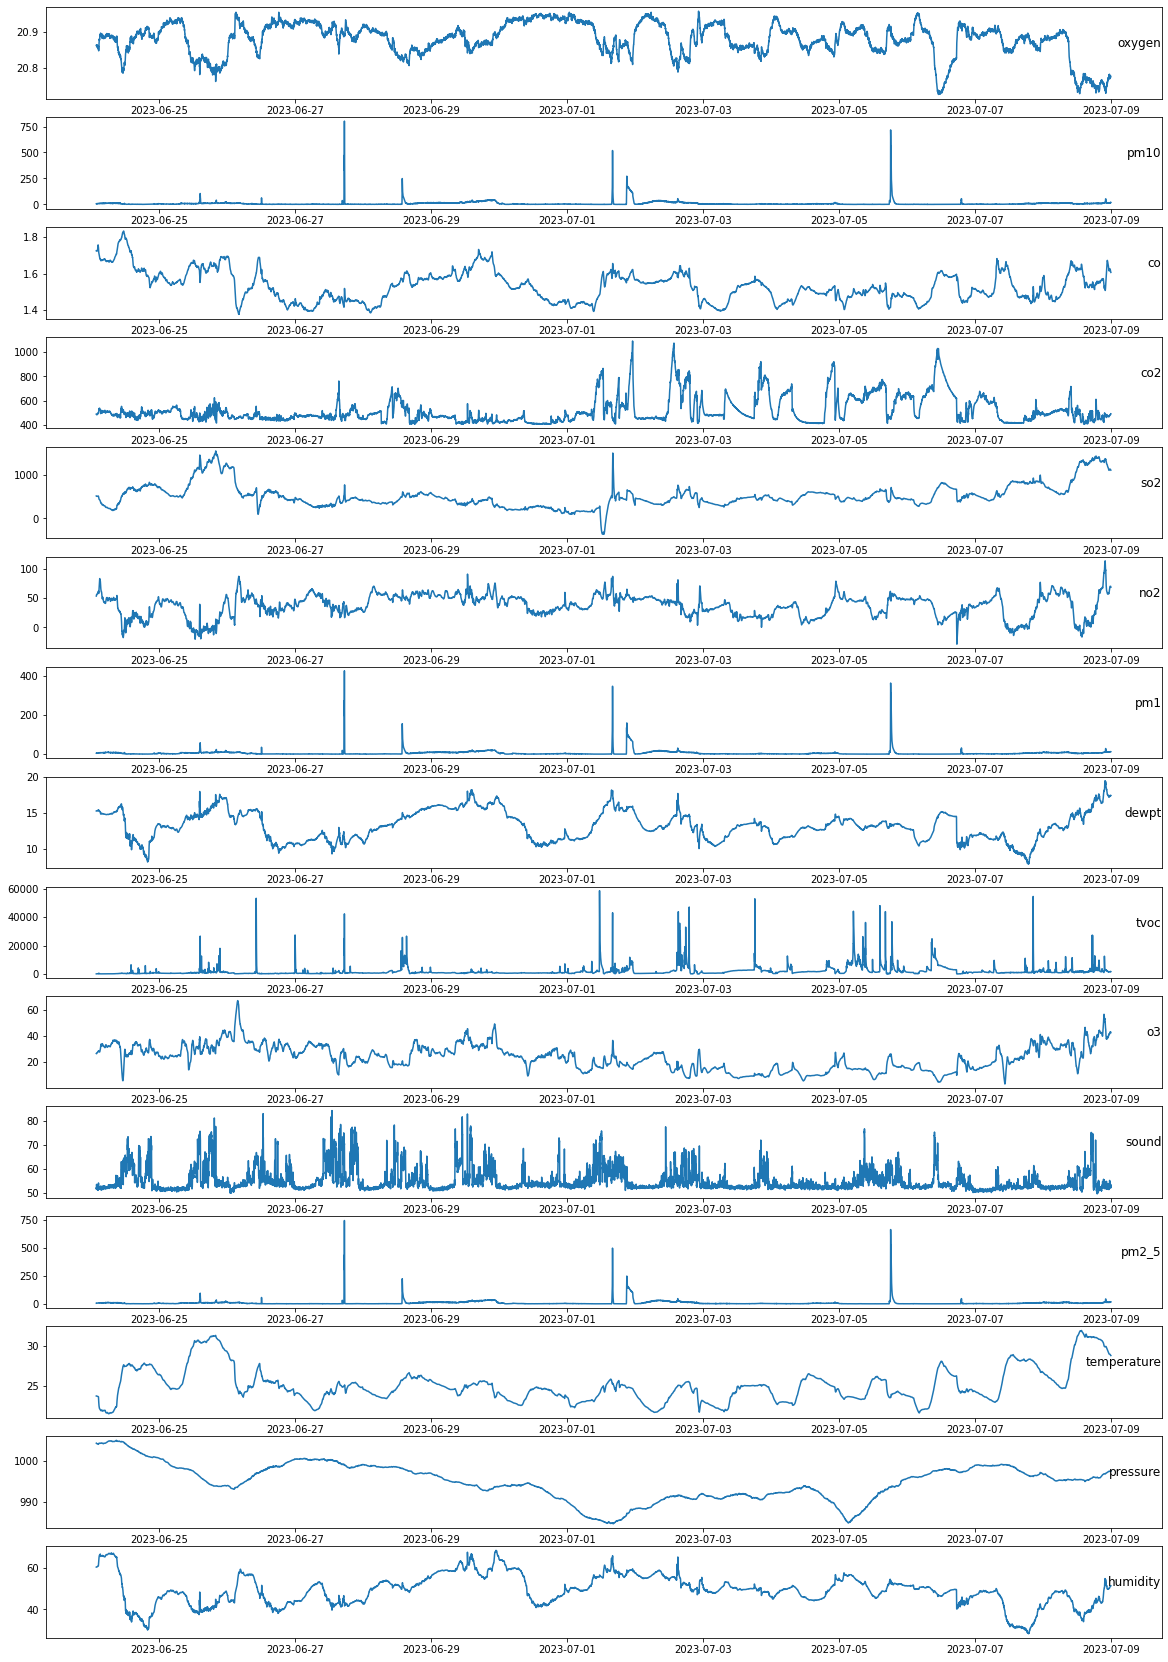

In [49]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

Voir la relation entre chaque paramètre et l'IQA

In [50]:
# data['IAQ'] = (data['pm1']<=10) & (data['pm2_5']<=25) & (data['pm10']<=50) & (data['co2']<800) & (data['tvoc']<300) & (data['o3']<18)
# data['IAQ'] = data['IAQ'].astype(object).replace({False: 0, True: 1})
# data.insert(0, 'IAQ', data.pop('IAQ'))

PM2.5 (Particulate Matter 2.5-micrometer)

PM2.5 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [51]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

data["PM2.5_SubIndex"] = data["pm2_5"].apply(lambda x: get_PM25_subindex(x))

PM10 (Particulate Matter 10-micrometer)

PM10 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [52]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

data["PM10_SubIndex"] = data["pm10"].apply(lambda x: get_PM10_subindex(x))

SO2 (Sulphur Dioxide)

SO2 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [53]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

data["SO2_SubIndex"] = data["so2"].apply(lambda x: get_SO2_subindex(x))

NO2 (Any Nitric x-oxide)

NO2 is measured in ppb (parts per billion). The predefined groups are defined in the function below:

In [54]:
## NOx Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

data["NO2_SubIndex"] = data["no2"].apply(lambda x: get_NO2_subindex(ugm3_to_ppb(x)))

CO (Carbon Monoxide)

CO is measured in mg / m3 (milligrams per cubic meter of air). The predefined groups are defined in the function below:

In [55]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

data["CO_SubIndex"] = data["co"].apply(lambda x: get_CO_subindex(ppm_to_mgm3(x)))

O3 (Ozone or Trioxygen)

O3 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [56]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

data["O3_SubIndex"] = data["o3"].apply(lambda x: get_O3_subindex(x))

AQI

The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

There is no theoretical upper value of AQI but its rare to find values over 1000.

In [57]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

data["Checks"] = (data["PM2.5_SubIndex"] > 0).astype(int) + \
                (data["PM10_SubIndex"] > 0).astype(int) + \
                (data["SO2_SubIndex"] > 0).astype(int) + \
                (data["NO2_SubIndex"] > 0).astype(int) + \
                (data["CO_SubIndex"] > 0).astype(int) + \
                (data["O3_SubIndex"] > 0).astype(int)

data["AQI_calculated"] = round(data[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NO2_SubIndex",
                                 "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
data.loc[data["PM2.5_SubIndex"] + data["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
data.loc[data.Checks < 3, "AQI_calculated"] = np.NaN

data["AQI_bucket_calculated"] = data["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
data.insert(0, 'AQI_calculated', data.pop('AQI_calculated'))
data.iloc[8560,:]
# data[~data.AQI_calculated.isna()].head(13)

AQI_calculated               213
oxygen                     20.88
pm10                       0.378
co                         1.478
co2                      653.599
so2                      435.914
no2                       47.601
pm1                        0.252
dewpt                     12.749
tvoc                     1146.37
o3                        15.342
sound                     52.323
pm2_5                      0.336
temperature               23.726
pressure                 995.882
humidity                  51.333
PM2.5_SubIndex              0.56
PM10_SubIndex              0.378
SO2_SubIndex             213.313
NO2_SubIndex             31.6224
CO_SubIndex              84.6601
O3_SubIndex               15.342
Checks                         6
AQI_bucket_calculated       Poor
Name: 2023-07-06 00:24:22, dtype: object

c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  """


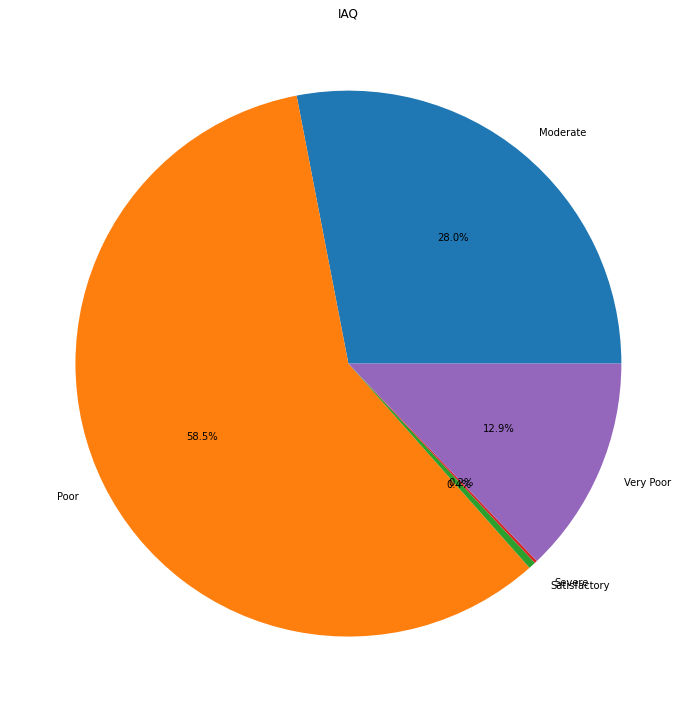

In [58]:
filtered_data = data['AQI_bucket_calculated'].dropna()
unique_values, counts = np.unique(filtered_data.values, return_counts=True)
proportions = counts / len(filtered_data)
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(proportions, labels=unique_values, autopct='%.1f%%')
ax.set_title('IAQ')
plt.tight_layout()
plt.show()

In [59]:
data.drop(['PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'NO2_SubIndex', 'CO_SubIndex', 'O3_SubIndex','Checks','AQI_bucket_calculated'], axis=1, inplace=True)
data

,AQI_calculated,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
date,,,,,,,,,,,,,,,,
2023-06-24 01:59:10,233.0,20.863,6.004,1.726,490.458,518.956,53.683,4.772,15.243,88.673,26.690,51.839,5.402,23.718,1004.360,60.385
2023-06-24 02:01:10,233.0,20.863,6.891,1.726,490.505,520.396,54.946,5.906,15.239,87.726,26.594,52.092,6.451,23.715,1004.340,60.377
2023-06-24 02:03:11,233.0,20.863,7.486,1.726,489.080,520.139,55.795,5.004,15.235,98.224,26.501,51.313,6.107,23.716,1004.320,60.358
2023-06-24 02:05:11,233.0,20.862,5.874,1.726,488.189,518.782,56.146,4.991,15.255,91.344,26.611,53.420,5.489,23.719,1004.300,60.426
2023-06-24 02:07:11,232.0,20.864,7.068,1.725,485.401,516.398,56.341,5.839,15.251,85.264,26.681,52.284,6.723,23.712,1004.280,60.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-08 23:50:26,341.0,20.778,15.895,1.616,485.832,1128.760,70.419,11.941,17.363,1522.430,43.174,52.033,14.813,28.801,997.579,51.186
2023-07-08 23:52:25,340.0,20.778,17.712,1.613,486.623,1123.330,70.439,12.091,17.372,1393.730,43.357,51.868,17.004,28.790,997.549,51.247
2023-07-08 23:54:26,340.0,20.778,15.942,1.611,487.518,1118.350,70.315,11.641,17.380,1451.100,43.350,52.146,15.244,28.779,997.534,51.304


In [60]:
d = data.corr()
display(d)

,AQI_calculated,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
AQI_calculated,1.000000,-0.658625,0.310931,0.347641,0.074670,0.945569,-0.355962,0.334167,0.241411,0.189136,0.214526,0.077378,0.316487,0.826142,0.199482,-0.483688
oxygen,-0.658625,1.000000,-0.083675,-0.538299,-0.379900,-0.682407,0.262147,-0.099734,-0.589558,-0.253354,0.028359,-0.205110,-0.084869,-0.737350,-0.073529,0.120042
pm10,0.310931,-0.083675,1.000000,0.135594,0.015047,0.086961,0.145248,0.994451,0.207206,0.252317,0.103494,0.083859,0.999307,0.013013,-0.097140,0.174187
co,0.347641,-0.538299,0.135594,1.000000,0.031835,0.354628,-0.143619,0.147324,0.606349,0.034506,0.220257,0.156498,0.136222,0.456679,0.213829,0.161436
co2,0.074670,-0.379900,0.015047,0.031835,1.000000,0.012197,0.023755,0.010824,0.139560,0.419033,-0.509930,0.087385,0.015352,-0.065665,-0.203618,0.147290
so2,0.945569,-0.682407,0.086961,0.354628,0.012197,1.000000,-0.389154,0.116932,0.274829,0.109988,0.275572,0.061561,0.091468,0.878911,0.197875,-0.498152
no2,-0.355962,0.262147,0.145248,-0.143619,0.023755,-0.389154,1.000000,0.140755,0.312170,0.001334,0.314445,-0.104622,0.140876,-0.514044,-0.101777,0.683111
pm1,0.334167,-0.099734,0.994451,0.147324,0.010824,0.116932,0.140755,1.000000,0.221787,0.258132,0.121678,0.078829,0.995906,0.038859,-0.086776,0.165491
dewpt,0.241411,-0.589558,0.207206,0.606349,0.139560,0.274829,0.312170,0.221787,1.000000,0.132168,0.259312,0.114135,0.206121,0.292945,-0.187010,0.602923
tvoc,0.189136,-0.253354,0.252317,0.034506,0.419033,0.109988,0.001334,0.258132,0.132168,1.000000,-0.249763,0.106284,0.253929,0.057067,-0.213156,0.053747


Une carte thermique（est un moyen de montrer la corrélation entre plusieurs variables à la fois.）

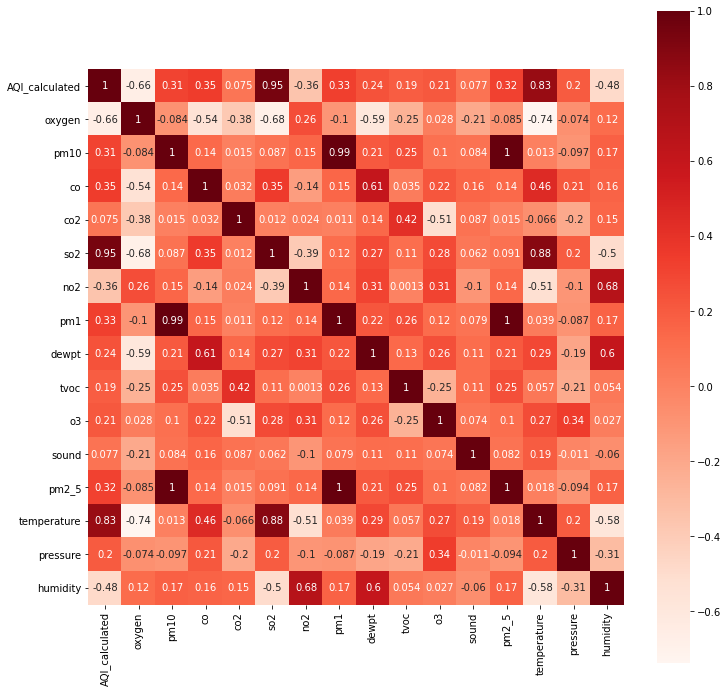

In [61]:
import seaborn as sns
plt.subplots(figsize = (12,12))
sns.heatmap(d,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

L'observation de la carte thermique permet de tirer les conclusions suivantes
1. **IAQ**(PM2.5, PM10, SO2, NO2, CO, O3)SO2>(-NO2)>CO>PM2.5>PM10>O3, Il est facile de voir que dans l'ensemble des données, le so2 affecte sérieusement la qualité de l'air.
2. **L'oxygène** est inversement corrélé avec T>SO2>dewpt>CO
3. Il existe une forte corrélation entre les PM10 et les PM1 et PM2.5.
4. CO：dewpt>T>SO2
5. Le NO2 est corrélé positivement avec l'humidité et négativement avec T
6. Corrélation positive entre le CO2 et le COVT
7. SO2 est positivement corrélé avec le T et le CO et négativement corrélé avec l'O2 > l'humidité > le NO2
8. Le NO2 est positivement corrélé avec l'humidité et négativement corrélé avec le T>SO2.

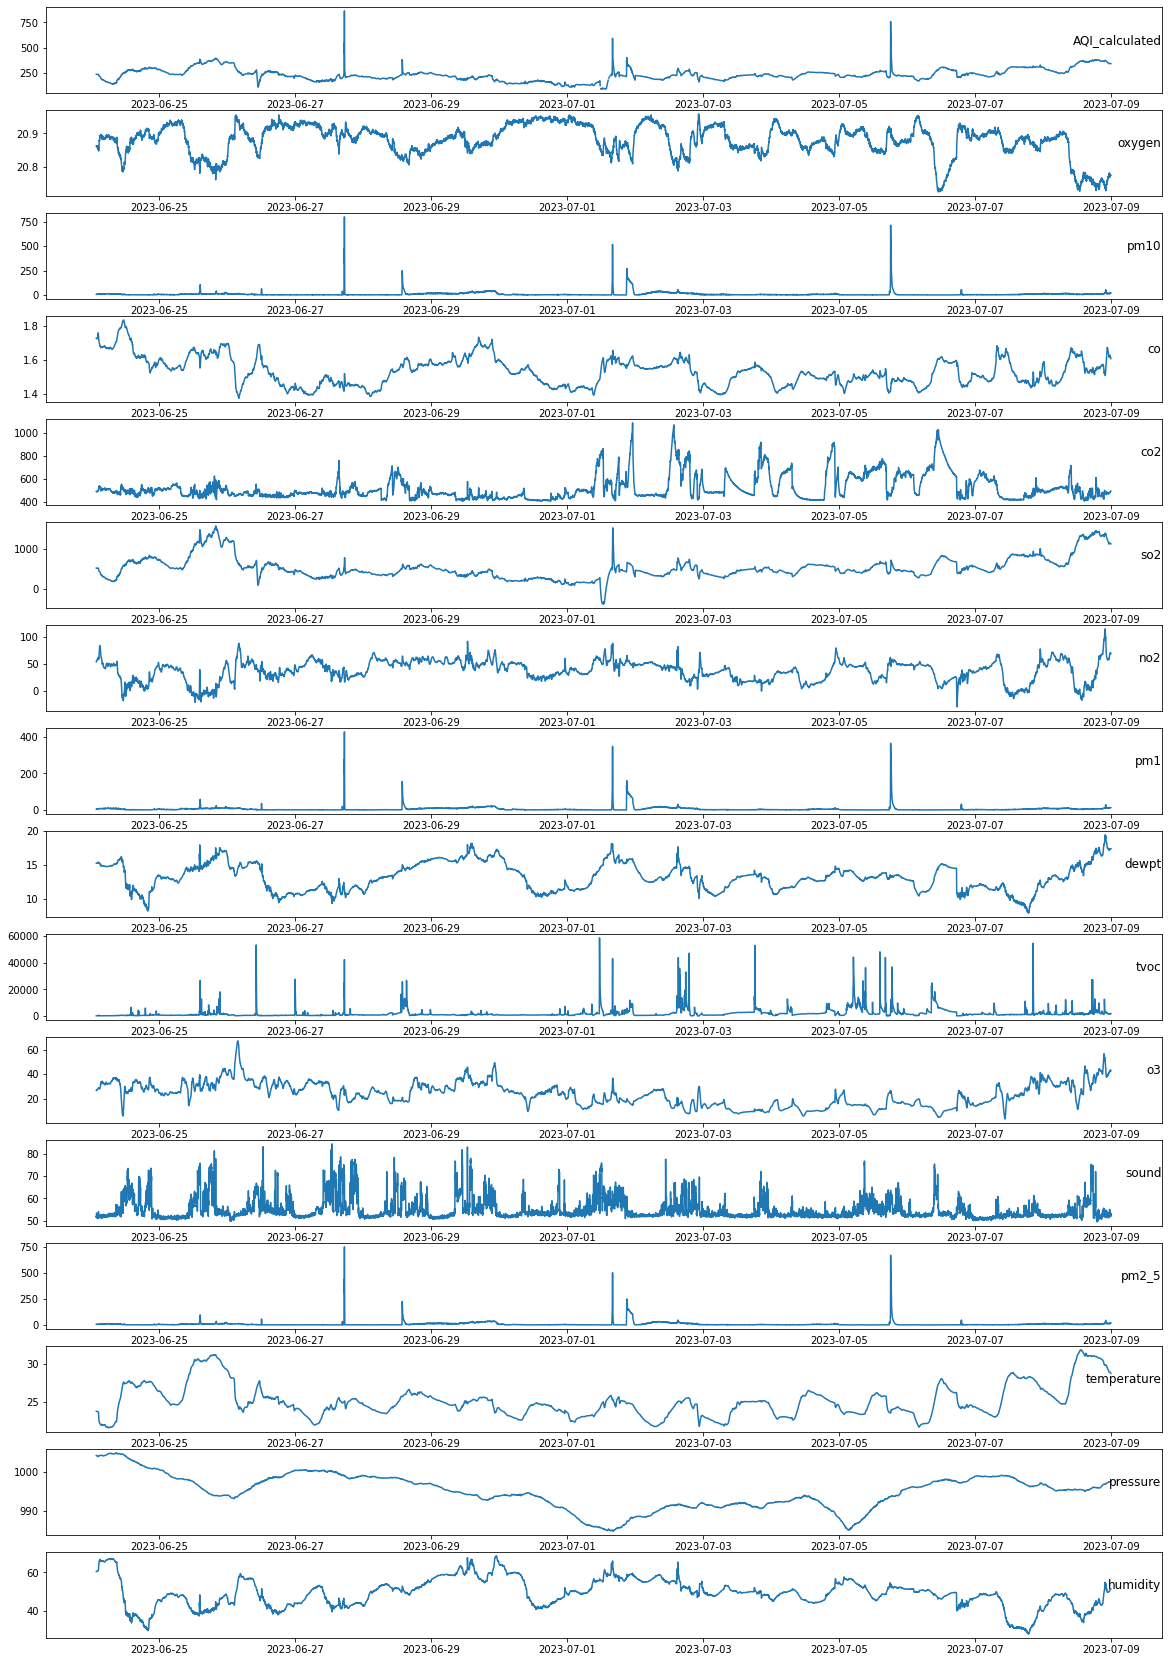

In [62]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14, 15]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

Les conclusions sont généralement correctes, certaines sont moins évidentes

Supprimer les IAQ pour éviter que diverses opérations n'affectent les données par la suite.